In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import math
import random
from tqdm import tqdm
import datetime

sns.set_style('darkgrid')
pd.options.display.max_rows = None

In [24]:
pairs = np.load('./item_purcharse_together/pairs.npy',allow_pickle=True).item()
uucf_df = pd.read_csv('./user-user_collaborative_filltering/uucf.csv')

transactions = pd.read_csv('../../data/transactions_train_sample.csv',dtype={"article_id": "str"})
transactions = transactions[['customer_id','article_id','t_dat']]
transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])

small_transactions = transactions.loc[transactions.customer_id.isin(uucf_df.customer_id)]

<AxesSubplot:xlabel='transaction_count', ylabel='Count'>

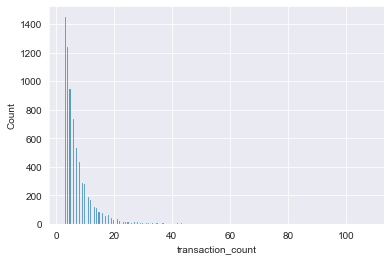

In [25]:
tmp = small_transactions.groupby('customer_id').article_id.count().reset_index()
tmp.columns = ['customer_id','transaction_count']
sns.histplot(data=tmp,x='transaction_count')

In [113]:
recommend_base_user = uucf_df[['customer_id']].copy()

### Find common purchase item

In [99]:
top100_items = small_transactions.article_id.value_counts().index[:12]

### Recommend base on purchase history and item frequently bought together

In [104]:
def recommend_on_hist(user_id):
    purchased_items = small_transactions.loc[
        small_transactions.customer_id == user_id,'article_id'].unique()

    item_score_map = {}
    for item in purchased_items:
        for ri,sc in pairs[item]:
            if ri in purchased_items: continue
            
            if ri not in item_score_map:
                item_score_map[ri] = sc
            else:
                item_score_map[ri] += sc
    
    item_score_map = sorted(list(item_score_map.items()),key=lambda x: x[1],reverse=True)

    recommended_items = [i[0] for i in item_score_map[:6]]
    
    # if len(recommended_items) < 6 ,we will fill with common purchased item last month
    while len(recommended_items) != 6:
        it = np.random.choice(top100_items)
        if it not in recommended_items:
            recommended_items.append(it)

    return recommended_items

In [116]:
recommend_base_user['buy_tgt'] = recommend_base_user.customer_id.apply(
                                    lambda x: ' '.join(recommend_on_hist(x))
                                )

### Recommmended using UUCF

In [123]:
recommend_base_user = recommend_base_user.merge(uucf_df,on='customer_id',how='left')

In [128]:
recommend_base_user.rename(columns={'prediction':'uucf'},inplace=True)

### Save result

In [150]:
recommend_base_user.to_csv('recommend_base_user.csv',index=False)

### Visualize prediction

In [153]:
recommend_base_user = pd.read_csv('recommend_base_user.csv')

cus_id: 4955a14d724bbfeec8bad94758758d1037d6bca2aa577b5d4daa5e6380fdd4c2

pred_buy_tgt : ['0881942002', '0866457001', '0903735002', '0903951001', '0373506001', '0852442003']


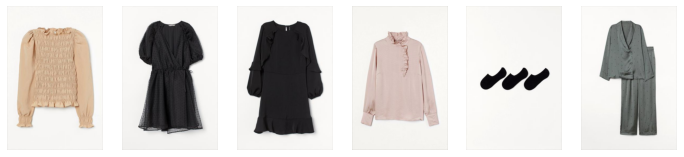

pred_uucf    : ['0881942002', '0852442003', '0916468002', '0859711001', '0884319006', '0936610001']


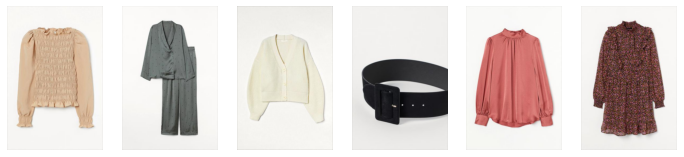

last_purchase: ['0879958001', '0918171001', '0881942001']


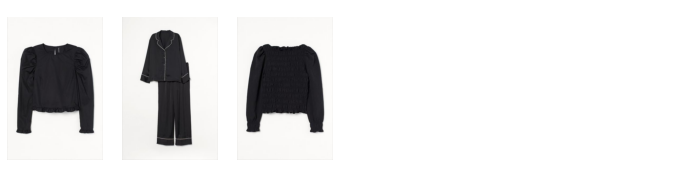

In [155]:
index = random.randint(0,recommend_base_user.shape[0]-1)

cus_id = recommend_base_user.iloc[index].customer_id
pred_buy_tgt = recommend_base_user.iloc[index].buy_tgt.split(' ')
pred_uucf = recommend_base_user.iloc[index].uucf.split(' ')

last_purchase = list(small_transactions.loc[
    small_transactions.customer_id == cus_id,
    'article_id'].unique())


print('cus_id:',cus_id,end='\n\n')

print('pred_buy_tgt :', pred_buy_tgt)
fig,axes = plt.subplots(nrows=1,ncols=6,figsize=(12,3))
axes = axes.flatten()
for im_id,ax in zip(pred_buy_tgt,axes):
    ax.axis('off')
    im = plt.imread(f'../../data/images/{im_id[:3]}/{im_id}.jpg')
    ax.imshow(im)
plt.show()

print('pred_uucf    :', pred_uucf)
fig,axes = plt.subplots(nrows=1,ncols=6,figsize=(12,3))
axes = axes.flatten()
for im_id,ax in zip(pred_uucf,axes):
    ax.axis('off')
    im = plt.imread(f'../../data/images/{im_id[:3]}/{im_id}.jpg')
    ax.imshow(im)
plt.show()

print('last_purchase:', last_purchase)
nr = math.ceil(len(last_purchase)/6)
fig,axes = plt.subplots(nrows=nr,ncols=6,figsize=(12,nr*3))
axes = axes.flatten()
last_purchase += [None]*(nr*6-len(last_purchase))
for im_id,ax in zip(last_purchase,axes):
    ax.axis('off')
    if im_id is not None:
        im = plt.imread(f'../../data/images/{im_id[:3]}/{im_id}.jpg')
        ax.imshow(im)
plt.show()